In [1]:
#install cfdb, needed for Jupyter notebook, deepnote using requirements.txt
#also install altair for Jupyter notebooks

#link to DeepNote shared space to execute notebook if Jupyter environement has API access blocked.
#https://deepnote.com/project/Show-Me-The-Money-chh6aYzUQLWP2T7TjJXpKw/%2Ffinal%20notebooks%2FCombined-ShowMeTheMoney.ipynb

In [2]:
#pip install altair

In [ ]:
#pip install cfbd

In [3]:
from __future__ import print_function
import pandas as pd
import numpy as np
import re
import time
import cfbd
from cfbd.rest import ApiException
from pprint import pprint
import io
import json
from pandas.io.json import json_normalize
from scipy.stats.stats import pearsonr
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt

# Configure API key authorization: ApiKeyAuth
configuration = cfbd.Configuration()
configuration.api_key['Authorization'] = 'Je9zk4J35DIxWQN6eb+taQSw4VgXxQ3gLsaqvGI9eTSScqKDjPVPiCPJ/2FjJ8oL'
configuration.api_key_prefix['Authorization'] = 'Bearer'

api_config = cfbd.ApiClient(configuration)

In [4]:
#read in College Financial Data as cfd, all cleaning will be done here
cfd = pd.read_csv('source/Collegiate Financial Data.csv')

#rename column to be more intuitive
cfd.rename(columns={'Data': 'Institution'}, inplace=True)

#identify which columns to keep for this dataset, create new data frame, and set index to common key for merging
cols_to_keep = ['Institution', 'IPEDS ID', 'Year', 'NCAA Subdivision', 'FBS Conference','Total Revenues',
'Coaches Compensation','Total Football Coaching Salaries']
new_cfd = pd.DataFrame(cfd,columns=cols_to_keep)
new_cfd = new_cfd.set_index('IPEDS ID')

In [5]:
#read in Department of Education file as deptofeduc, all cleaning will be done here
deptofeduc = pd.read_csv('source/InstitutionCampus.csv')

#to keep the names the same across the two files, renaming to IPEDS ID
deptofeduc.rename(columns={'IpedsUnitIds': 'IPEDS ID'}, inplace=True)

#only need the address info from this file to merge with the financial data
#this will be used as a common key for the college football database API
doe_cols_to_keep=['IPEDS ID', 'LocationName','LocationType', 'Address']
new_doe = pd.DataFrame(deptofeduc,columns=doe_cols_to_keep)

#filter out unnecessary data keeping only the schools and those with standard 6 digit IPEDS IDs
doe = new_doe[(new_doe['LocationType'] == 'Institution')]
doe = doe[doe['IPEDS ID'].str.len() == 6]

#peel off any ZIPs that have the trailing 4 digits and then delete that column
doe[['Address','last4']] = doe.Address.str.split('-',n=1,expand=True)
doe.drop('last4',axis=1,inplace=True)

#regex to get separate columns with city,state zip and city 
doe[['City, State','City']] = doe['Address'].str.extract(r'((\w[^,]+\s?),\s[A-Z]{2})', expand=False)

#after review, there's a need to replace a few incorrect city locations, correct spelling, and change PO boxes
doe = doe.replace({'City, State' : {'University, MS':'Oxford, MS', 'Auburn University, AL':'Auburn, AL',
                                      'Suite 3300, US':'Colorado Springs, CO','West  Point, NY':'West Point, NY',
                                      'Mississippi State, MS':'Starkville, MS','Dekalb, IL':'DeKalb, IL',
                                      'Dallas, TX':'University Park, TX','Winston Salem, NC':'Winston-Salem, NC',
                                      'P. O. Box 4219, MS':'Lubbock, TX','Buffalo, NY':'Amherst, NY'}})

#add column for just the ZIP
doe['ZIP'] = doe['Address'].str.extract(r'(\d{5})', expand=False)

#change IPEDS ID column to integer filling in NaNs with 0
doe['IPEDS ID'] = doe['IPEDS ID'].fillna(0).astype(int)
doe = doe.set_index('IPEDS ID')
doe = doe.reset_index()

#replace incorrect IPEDS ID
doe['IPEDS ID'] = doe['IPEDS ID'].replace(495767, 214777)

#differentiate schools with the same city, state
doe.loc[doe['IPEDS ID'] == 110662, 'City, State'] = 'Pasadena, CA'
doe.loc[doe['IPEDS ID'] == 225511, 'City, State'] = 'DT Houston, TX'
doe.loc[doe['IPEDS ID'] == 139940, 'City, State'] = 'DT Atlanta, GA'

#remove column that is no longer necessary
doe.drop('Address',axis=1,inplace=True)

In [6]:
#this method works to merge Financial Data and Dept of Ed info
mergedData = doe.merge(new_cfd, on = ['IPEDS ID'], how = 'left')

#identify columns to keep for our final df
final_cols_to_keep=['IPEDS ID', 'Institution', 'Year', 'NCAA Subdivision', 'FBS Conference',
       'Total Revenues', 'Coaches Compensation',
       'Total Football Coaching Salaries', 'City, State']

cfd_doe = pd.DataFrame(mergedData,columns=final_cols_to_keep)

#filter on the years we want to use 2010-2019
cfd_doe = cfd_doe[(cfd_doe['Year'] >= 2010)]

#filter out years/teams that did not have football programs
#anomaly detected - Georgia State had no football in 2010, in the FCS from 2011-2013, and FBS from 2014-present
cfd_doe = cfd_doe[(cfd_doe['NCAA Subdivision'] != 'No Football Subdivision')]

#convert dollar values to integers
cfd_doe['Total Revenues'] = cfd_doe['Total Revenues'].replace('[\$,]', '', regex=True).fillna(0).astype(int)
cfd_doe['Coaches Compensation'] = cfd_doe['Coaches Compensation'].replace('[\$,]', '', regex=True).fillna(0).astype(int)
cfd_doe['Total Football Coaching Salaries'] = cfd_doe['Total Football Coaching Salaries'].replace('[\$,]', '', regex=True).fillna(0).astype(int)

#change to a standard conference naming convention to prep for merging with the next dataset
cfd_doe = cfd_doe.replace({'FBS Conference' : {'American Athletic Conference':'American Athletic', 'Atlantic Coast Conference':'ACC',
                                      'Big 12 Conference':'Big 12','Big East Conference':'Big East',
                                      'Big Ten Conference':'Big Ten','Independent':'FBS Independents',
                                      'Mid-American Conference':'Mid-American','Mountain West Conference':'Mountain West',
                                      'Pacific-12 Conference':'Pac-12','Southeastern Conference':'SEC',
                                      'Sun Belt Conference':'Sun Belt','Western Athletic Conference':'Western Athletic'}})

#create common key
cfd_doe['common_key'] = cfd_doe['FBS Conference'] + " - " + cfd_doe['City, State']

In [7]:
#address dataframe
teams = cfbd.TeamsApi(api_config).get_teams()
data = pd.DataFrame.from_records([g.to_dict() for g in teams])
new_data = pd.json_normalize(data["location"])
newest_data = pd.concat([data,new_data],axis=1)
wanted_columns = ['school', 'mascot', 'abbreviation', 'conference', 'division', 'logos', 'city', 'state', 'zip']
team_addresses = pd.DataFrame(newest_data,columns=wanted_columns)
team_addresses['team_location'] = team_addresses['city'].astype(str) + ', ' + team_addresses['state'].astype(str)
team_addresses = team_addresses.dropna(subset=['city', 'state'])
team_addresses = team_addresses.reset_index(drop = True)

#setting up the teams record via the API
seasons = [cfbd.GamesApi(api_config).get_team_records(year=iteryear) for iteryear in range(2010,2020)]
games = [game for season in seasons for game in season]
exclude = ['away_games', 'home_games', 'conference_games']
first = pd.DataFrame.from_records([g.to_dict() for g in games], exclude=exclude)
second = pd.json_normalize(first['total'])
team_records = pd.concat([first,second],axis=1)
team_records = team_records.drop(['total'], axis = 1)

#merge team information and wins
new_df = team_records.merge(team_addresses, left_on='team', right_on='school')

final_columns = ['year', 'team', 'conference_x', 'division_x', 'expected_wins', 'games',
       'wins', 'losses', 'ties', 'mascot', 'abbreviation', 'logos', 
       'team_location']

cfbd_final = pd.DataFrame(new_df,columns=final_columns)

#updates and corrections made; then created the common key for merging
cfbd_final = cfbd_final.replace({'team_location' : {'East Hartford, CT':'Storrs, CT', 'Miami Gardens, FL':'Coral Gables, FL',
                                      'Piscataway, NJ':'New Brunswick, NJ','Hadley, MA':'Amherst, MA',
                                      'Whitney, NV':'Las Vegas, NV','Lexington, VA':'Champaign, IL'}})

cfbd_final.loc[cfbd_final['team'] == 'Houston', 'team_location'] = 'DT Houston, TX'
cfbd_final.loc[cfbd_final['team'] == 'Georgia State', 'team_location'] = 'DT Atlanta, GA'

#update pac 10 to pac 12 for consistency
cfbd_final = cfbd_final.replace({'conference_x' : {
                                      'Pac-10':'Pac-12'}})

#return the first item in each list of logo files
cfbd_final['logos'] = cfbd_final['logos'].str[0]

cfbd_final['Common_key'] = cfbd_final['conference_x'] + " - " + cfbd_final['team_location']

In [8]:
#merge the College Football Data with the Financial Data on a common key
go_blue_beat_uga = cfbd_final.merge(cfd_doe, left_on=['Common_key', 'year'], right_on=['common_key', 'Year'])

#determine columns to keep
clean_columns = ['year', 'team', 'conference_x', 'division_x', 'expected_wins', 'games',
       'wins', 'losses', 'mascot', 'logos', 'City, State', 'IPEDS ID', 'NCAA Subdivision', 
       'Total Revenues','Coaches Compensation', 'Total Football Coaching Salaries']

#create final merged dataframe       
go_blue = pd.DataFrame(go_blue_beat_uga, columns=clean_columns)

#calculate win loss percentage per year; includes conference championships and bowl games
go_blue['Winning %'] = round(go_blue['wins'] / go_blue['games'],3)

#calculate the Football coaches salary per game
go_blue['FB_Salary/Game ($)'] = round(go_blue['Total Football Coaching Salaries'] / go_blue['games'],2)

#calculate how much the total Football coaches salary is to total school revenue
go_blue['FB_Salary/Revenue (%)'] = round(go_blue['Total Football Coaching Salaries'] / go_blue['Total Revenues'],3)

#calculate average revenue per game
go_blue['Revenue/Game ($)'] = round(go_blue['Total Revenues'] / go_blue['games'],2)

#calculate what percent of the total coaches salaries is for football 
go_blue['FB_Salary/Total_Coaches_Calary (%)'] = round(go_blue['Total Football Coaching Salaries'] 
                                                  / go_blue['Coaches Compensation'],3)

#add in conference logos
conf_logo = {'American Athletic':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/american.png', 
'ACC':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/acc.png',
'Big 12':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/big_12.png',
'Big East':'http://cdn.bleacherreport.net/images/team_logos/328x328/big_east_basketball.png',
'Big Ten':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/big_ten.png',
'FBS Independents':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/ia_independents.png',
'Mid-American':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/mac.png',
'Mountain West':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/mountain_west.png',
'Pac-12':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/pac_12.png',
'SEC':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/sec.png',
'Sun Belt':'https://a.espncdn.com/combiner/i?img=/i/teamlogos/ncaa_conf/500/sun_belt.png',
'Western Athletic':'https://upload.wikimedia.org/wikipedia/commons/f/f5/Logo_WAC.png'}

go_blue['Conference_Logo'] = go_blue['conference_x'].map(conf_logo)

#Function creates categorical a column called Group, labels if team is a Power 5 or Group of 5+
def Power_group(school):
    #list of Power 5 and Group of 5 conferences
    power5 = ['ACC','Big 12','Big Ten','Pac-12','SEC']
    groupof5 = ['American Athletic','Conference USA','Mid-American','Mountain West','Sun Belt']
    
    if school in power5:
        group ='Power 5'
    else: 
        group = 'Group of 5+'

    return group

#Apply Power_Five function to "Power_5" column
go_blue['Group']=go_blue['conference_x'].apply(lambda x: Power_group(x))

#Add Notre Dame to Power 5
go_blue.loc[go_blue['team'] == 'Notre Dame', 'Group'] = 'Power 5'

showMEtheMONEY = go_blue.rename(columns={'year':'Year','team':'School','conference_x':'Conference','division_x':'Conference_Division',
                       'expected_wins':'Expected_Wins','games':'Games_Played','wins':'Wins','losses':'Losses',
                       'mascot':'School_Nickname','logos':'School_Logo'})


In [9]:
#taking a peek at the dataframe
showMEtheMONEY

,Year,School,Conference,Conference_Division,Expected_Wins,Games_Played,Wins,Losses,School_Nickname,School_Logo,...,Total Revenues,Coaches Compensation,Total Football Coaching Salaries,Winning %,FB_Salary/Game ($),FB_Salary/Revenue (%),Revenue/Game ($),FB_Salary/Total_Coaches_Calary (%),Conference_Logo,Group
0,2010,Air Force,Mountain West,,8.1,13,9,4,Falcons,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...,...,34915251,9371918,3519326,0.692,270717.38,0.101,2685788.54,0.376,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
1,2011,Air Force,Mountain West,,7.5,13,7,6,Falcons,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...,...,39823782,10745839,3705803,0.538,285061.77,0.093,3063367.85,0.345,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
2,2012,Air Force,Mountain West,,7.5,13,6,7,Falcons,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...,...,44490055,10789112,3935207,0.462,302708.23,0.088,3422311.92,0.365,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
3,2013,Air Force,Mountain West,Mountain,4.9,12,2,10,Falcons,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...,...,39031348,10270921,3938778,0.167,328231.50,0.101,3252612.33,0.383,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
4,2014,Air Force,Mountain West,Mountain,9.7,13,10,3,Falcons,http://a.espncdn.com/i/teamlogos/ncaa/500/2005...,...,46577840,10608013,4300330,0.769,330794.62,0.092,3582910.77,0.405,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1209,2019,Charlotte,Conference USA,East,7.5,13,7,6,49ers,http://a.espncdn.com/i/teamlogos/ncaa/500/2429...,...,40866430,6525215,2303482,0.538,177190.92,0.056,3143571.54,0.353,NaN,Group of 5+
1210,2017,Coastal Carolina,Sun Belt,,3.7,12,3,9,Chanticleers,http://a.espncdn.com/i/teamlogos/ncaa/500/324.png,...,33703994,5553763,1718546,0.250,143212.17,0.051,2808666.17,0.309,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
1211,2018,Coastal Carolina,Sun Belt,,4.7,12,5,7,Chanticleers,http://a.espncdn.com/i/teamlogos/ncaa/500/324.png,...,36392897,6484248,1996362,0.417,166363.50,0.055,3032741.42,0.308,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+
1212,2019,Coastal Carolina,Sun Belt,,5.2,12,5,7,Chanticleers,http://a.espncdn.com/i/teamlogos/ncaa/500/324.png,...,37885828,7005059,2221117,0.417,185093.08,0.059,3157152.33,0.317,https://a.espncdn.com/combiner/i?img=/i/teamlo...,Group of 5+


In [10]:
#save file as csv for offline checking
#showMEtheMONEY.to_csv('/work/ShowMeTheMoney.csv')

In [11]:
#viz for grouping revenue and year and separate out power5 and group of 5+ to get desired 
#non-stacked chart result that doesn't require using opacity

#set as datetime series for altair, don't know why but it works
showMEtheMONEY['Year'] = pd.to_datetime(showMEtheMONEY['Year'], format='%Y')

#same colors as presentation boxes 
domain = ['Power 5', 'Group of 5+']
range_ = ['#a4c2f4ff', '#fff2ccff']

#filter on each group for visuals
power5 = showMEtheMONEY[showMEtheMONEY['Group']=='Power 5']
group5 = showMEtheMONEY[showMEtheMONEY['Group']=='Group of 5+']

#area chart for the power 5 coach salary totals by year
sal_year_P5 = alt.Chart(power5).mark_area().encode(
    x = alt.X('year(Year):T',axis=alt.Axis(title=None, format='%Y')),
    y = alt.Y('sum(Total Football Coaching Salaries):Q',axis=alt.Axis(title=None)),
    color = alt.Color('Group:N', legend=alt.Legend(title=None, orient='none'),scale=alt.Scale(domain=domain, range=range_))
).properties(
    height=150,
    width=400,
    title='Total Football Coaching Salary Growth ($)'
)

#area chart for the group of 5+ coach salary totals by year
sal_year_G5 = alt.Chart(group5).mark_area().encode(
    x = alt.X('year(Year):T',axis=alt.Axis(title=None, format='%Y')),
    y = alt.Y('sum(Total Football Coaching Salaries):Q',axis=alt.Axis(title=None)),
    color = alt.Color('Group:N', legend=alt.Legend(title=None, orient='none'),scale=alt.Scale(domain=domain, range=range_))
).properties(
    height=150,
    width=400,
    title='Total Football Coaching Salary Growth ($)'
)

#area chart for the power 5 revenue totals by year
rev_year_P5 = alt.Chart(power5).mark_area().encode(
    x = alt.X('year(Year):T',axis=alt.Axis(title=None, format='%Y')),
    y = alt.Y('sum(Total Revenues):Q',stack=None,axis=alt.Axis(title=None)),
    color = alt.Color('Group:N', legend=alt.Legend(title=None, orient='none'),scale=alt.Scale(domain=domain, range=range_))
).properties(
    height=150,
    width=400,
    title='Total Revenue Growth ($)'
)

#area chart for the group of 5+ revenue totals by year
rev_year_G5 = alt.Chart(group5).mark_area().encode(
    x = alt.X('year(Year):T',axis=alt.Axis(title=None, format='%Y')),
    y = alt.Y('sum(Total Revenues):Q',stack=None,axis=alt.Axis(title=None)),
    color = alt.Color('Group:N', legend=alt.Legend(title=None, orient='none'),scale=alt.Scale(domain=domain, range=range_))
).properties(
    height=150,
    width=400,
    title='Total Revenue Growth ($)'
)

#layer the salary and revenue charts then vertically concatenate them
(sal_year_P5 + sal_year_G5) & (rev_year_P5 + rev_year_G5)

alt.VConcatChart(...)

In [12]:
#formatter to be used later
def format_number(data_value, indx):
    if data_value >= 1_000_000:
        formatter = '{:1.1f}M'.format(data_value*0.000_001)
    else:
        formatter = '{:1.0f}K'.format(data_value*0.001)
    return formatter

In [13]:
#year back to datetime year
showMEtheMONEY['Year'] = pd.to_datetime(showMEtheMONEY['Year']).dt.year

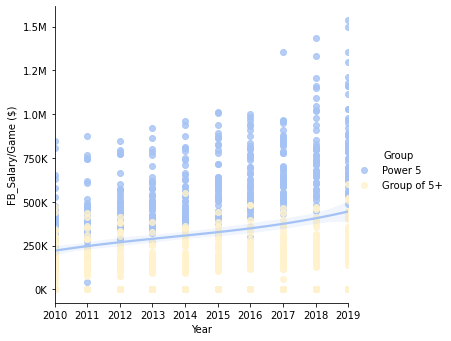

In [14]:
#Seaborn chart
#the colors we want to use

colors = ['#a4c2f4ff', '#fff2ccff']

# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

ax = sns.lmplot(x='Year', y='FB_Salary/Game ($)', data=showMEtheMONEY, hue='Group', hue_order = ['Power 5','Group of 5+'], fit_reg=False )

ax.axes[0, 0].set_xlim((2010, 2019))

#Trend line t
g=sns.regplot(x='Year', y='FB_Salary/Game ($)', data=showMEtheMONEY, scatter=False, ax=ax.axes[0, 0], order=3)

plt.yticks(np.arange(0,max(showMEtheMONEY['FB_Salary/Game ($)'])+1,250000))

g.yaxis.set_major_formatter(format_number)


plt.show()

In [15]:
#calcuating the needed statistics

year_rev = showMEtheMONEY.groupby(['Group'])['Total Revenues'].sum()

year_coach = showMEtheMONEY.groupby(['Group'])['Total Football Coaching Salaries'].sum()

year_wins = showMEtheMONEY.groupby(['Group'])['Wins'].sum()

In [16]:
#Coaches Salary / Wins Per Year
round((year_coach / year_wins),0)

Group
Group of 5+    360048.0
Power 5        827059.0
dtype: float64

In [17]:
#Coaches Salary / School Revenue
round((year_coach / year_rev) *100,2)

Group
Group of 5+    7.40
Power 5        7.34
dtype: float64

In [18]:
#School Revenue / Wins Per year
round((year_rev / year_wins),0)

Group
Group of 5+     4864041.0
Power 5        11271592.0
dtype: float64

In [19]:
#needed for calcuating regressions for created statistics
#removed those with zero coaching salary as they'd wrongly impact the results
adjusted_df = showMEtheMONEY[showMEtheMONEY['Total Football Coaching Salaries'] != 0]
adjusted_p5 = adjusted_df[adjusted_df['Group'] == 'Power 5']
adjusted_g5 = adjusted_df[adjusted_df['Group'] == 'Group of 5+']

In [20]:
#overall correlation and r2 - salaries and wins
np.corrcoef(adjusted_df['Total Football Coaching Salaries'], adjusted_df['Wins'])[0,1], np.corrcoef(adjusted_df['Total Football Coaching Salaries'], adjusted_df['Wins'])[0,1] ** 2

(0.3715699451025759, 0.13806422410353128)

In [21]:
#power 5 correlation and r2 - salaries and wins
np.corrcoef(adjusted_p5['Total Football Coaching Salaries'], adjusted_p5['Wins'])[0,1], np.corrcoef(adjusted_p5['Total Football Coaching Salaries'], adjusted_p5['Wins'])[0,1] ** 2

(0.39091502962749797, 0.15281456038866761)

In [22]:
#group of 5 correlation and r2 - salaries and wins
np.corrcoef(adjusted_g5['Total Football Coaching Salaries'], adjusted_g5['Wins'])[0,1], np.corrcoef(adjusted_g5['Total Football Coaching Salaries'], adjusted_g5['Wins'])[0,1] ** 2

(0.25114092469445676, 0.0630717640563868)

In [23]:
#overall correlation and r2 - salaries and school revenue
np.corrcoef(adjusted_df['Total Football Coaching Salaries'], adjusted_df['Total Revenues'])[0,1], np.corrcoef(adjusted_df['Total Football Coaching Salaries'], adjusted_df['Total Revenues'])[0,1] ** 2

(0.9159569286209986, 0.8389770950888132)

In [24]:
#power 5 correlation and r2 - salaries and school revenue
np.corrcoef(adjusted_p5['Total Football Coaching Salaries'], adjusted_p5['Total Revenues'])[0,1], np.corrcoef(adjusted_p5['Total Football Coaching Salaries'], adjusted_p5['Total Revenues'])[0,1] ** 2

(0.8135296611950339, 0.6618305096441066)

In [25]:
#group of 5 correlation and r2 - salaries and school revenue
np.corrcoef(adjusted_g5['Total Football Coaching Salaries'], adjusted_g5['Total Revenues'])[0,1], np.corrcoef(adjusted_g5['Total Football Coaching Salaries'], adjusted_g5['Total Revenues'])[0,1] ** 2

(0.7546208952455881, 0.5694526955412528)

In [26]:
#overall correlation and r2 - school revenue and wins
np.corrcoef(adjusted_df['Total Revenues'], adjusted_df['Wins'])[0,1], np.corrcoef(adjusted_df['Total Revenues'], adjusted_df['Wins'])[0,1] ** 2

(0.3090444744415767, 0.09550848718287035)

In [27]:
#power 5 correlation and r2 - school revenue and wins
np.corrcoef(adjusted_p5['Total Revenues'], adjusted_p5['Wins'])[0,1], np.corrcoef(adjusted_p5['Total Revenues'], adjusted_p5['Wins'])[0,1] ** 2

(0.32202194769848286, 0.10369813479952443)

In [28]:
#group of 5 correlation and r2 - school revenue and wins
np.corrcoef(adjusted_g5['Total Revenues'], adjusted_g5['Wins'])[0,1], np.corrcoef(adjusted_g5['Total Revenues'], adjusted_g5['Wins'])[0,1] ** 2

(0.07222921414591185, 0.005217059376135993)

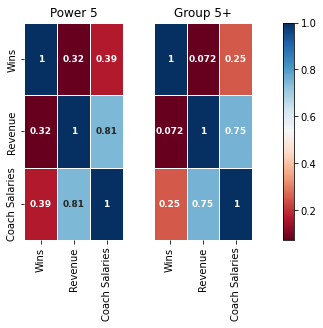

In [29]:
#Creating the heat map for the correlations
heat_map_p = adjusted_df.rename(columns={'Total Revenues':'Revenue','Total Football Coaching Salaries':'Coach Salaries'})
hm_p5_X = heat_map_p[heat_map_p['Group']=='Power 5']
hm_g5_Y = heat_map_p[heat_map_p['Group']!='Power 5']

#looking at significance level acrosss each variable to identify any correlation. No strong correlation in wins an other variables 
x = hm_p5_X[['Wins','Revenue','Coach Salaries']]
y = hm_g5_Y[['Wins','Revenue','Coach Salaries']]
corrX = x.corr()
corrY = y.corr()

#Set Ax and FigSize
fig, (ax1, ax2) = plt.subplots(ncols=2)

sns.heatmap(corrX,annot=True,xticklabels=corrX.columns.values,ax = ax1, cbar=False, 
yticklabels=corrX.columns.values,cmap='RdBu',annot_kws={'fontsize':9,'fontweight':'bold'},linewidth=1).set(title='Power 5')
fig.colorbar(ax1.collections[0], ax=ax1, location="left", use_gridspec=False, pad=0.2)
fig.axes[2].set_visible(False)

sns.heatmap(corrY,annot=True,ax = ax2,cbar=False,cmap="RdBu",xticklabels=corrX.columns.values,
yticklabels=False,annot_kws={'fontsize':9,'fontweight':'bold'},linewidth=1).set(title='Group 5+')
fig.colorbar(ax2.collections[0], ax=ax2, location="right", use_gridspec=False, pad=0.2)

#ax2.yaxis.tick_right()
#fig.subplots_adjust(top=0.9) # adjust the Figure in rp

plt.show()

In [30]:
#paying for coaches and wins visual

overall_win = alt.Chart(showMEtheMONEY[showMEtheMONEY['Total Football Coaching Salaries'] != 0]).mark_image(width=25, height=25).encode(
    x = alt.X('Total Football Coaching Salaries:Q', axis=alt.Axis(title='Total Football Coaching Salaries ($)')),
    y = alt.Y('Wins'),
    url='School_Logo'
).properties(
    width=600,
    height=400,
    title='Can You Buy Wins? No.'
)

overall_win + overall_win.transform_regression('Total Football Coaching Salaries','Wins').mark_line()

alt.LayerChart(...)

In [31]:
#expected win chart

expwin = alt.Chart(showMEtheMONEY).mark_image(width=25, height=25).encode(
    x = alt.X('sum(Expected_Wins):Q',axis=alt.Axis(title='Total Expected Wins')),
    y = alt.Y('sum(Wins):Q',axis=alt.Axis(title='Total Wins')),
    url='School_Logo'
).properties(
    width=600,
    height=400,
    title='Success? Total Expected Wins and Total Actual Wins Scatterplot'
)

expwin + expwin.transform_regression('Expected_Wins','Wins').mark_line(color='black')

alt.LayerChart(...)

In [32]:
#correlation chart for schools at either end of the results - good and bad

showmestack = adjusted_df.groupby('School')[['Winning %','FB_Salary/Game ($)']].corr().unstack().iloc[:,1].round(3)

df1 = adjusted_df.groupby(['School','School_Logo','Group']).agg({'Winning %':(np.nanmean),'FB_Salary/Game ($)':(np.nanmean)}).round(2).reset_index()

df1['Corr'] = df1['School'].apply(lambda x: showmestack.loc[x])

df2 = df1[(df1['Corr'] >= .66) | (df1['Corr']<= -.66)].sort_values(by='Corr',ascending=False)

Pos = df2[df2['Corr']>= .66]
Neg = df2[df2['Corr']<= -.66]

P = alt.Chart(Pos).mark_image(width=32, height=30).encode(
  x=alt.X('Corr:Q', scale=alt.Scale(zero=True),axis=alt.Axis(title='')),
  y=alt.Y('School:N',axis=alt.Axis(title='',orient='right')),
  url='School_Logo').properties(title='Success',
  width=200,height=300)

N = alt.Chart(Neg).mark_image(width=32, height=30).encode(
  x=alt.X('Corr:Q', scale=alt.Scale(zero=True),axis=alt.Axis(title='')),
  y=alt.Y('School:N',axis=alt.Axis(title='')),
  url='School_Logo').properties(title='Paying To Lose',
    width=200,height=300)

N|P


alt.HConcatChart(...)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=72187a69-8cd4-40b5-8fd9-3ed38c95e92b' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>